## Logistic regression

### 0. Iris flower dataset

In [413]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

a)

In [414]:
iris = datasets.load_iris(as_frame=True)
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [415]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

b)

In [416]:
df = iris["frame"]
df["specie_name"] = df.target.replace(dict(enumerate(iris.target_names)))
df.rename(columns={"target" : "specie"}, inplace=True)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),specie,specie_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


c)

In [417]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   specie             150 non-null    int64  
 5   specie_name        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [418]:
df.describe().T.drop("specie", axis=0)

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


<AxesSubplot:xlabel='petal width (cm)', ylabel='petal length (cm)'>

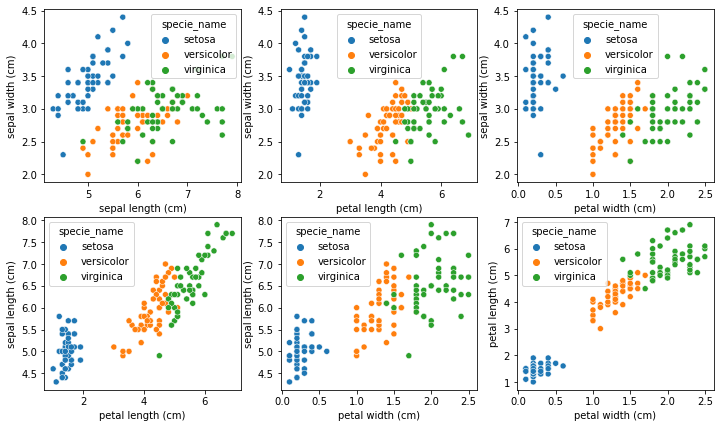

In [419]:
fig, axes = plt.subplots(2, 3, figsize=(12,7))
sns.scatterplot(data=df, x="sepal length (cm)", y="sepal width (cm)", hue="specie_name", ax = axes[0,0])
sns.scatterplot(data=df, x="petal length (cm)", y="sepal width (cm)", hue="specie_name", ax = axes[0,1])
sns.scatterplot(data=df, x="petal width (cm)", y="sepal width (cm)", hue="specie_name", ax = axes[0,2])

sns.scatterplot(data=df, x="petal length (cm)", y="sepal length (cm)", hue="specie_name", ax = axes[1,0])
sns.scatterplot(data=df, x="petal width (cm)", y="sepal length (cm)", hue="specie_name", ax = axes[1,1])

sns.scatterplot(data=df, x="petal width (cm)", y="petal length (cm)", hue="specie_name", ax = axes[1,2])

d)

<AxesSubplot:>

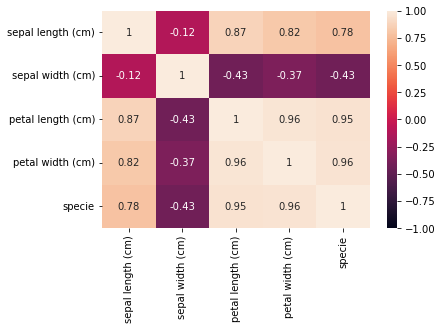

In [420]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

- 1 means that when one variable increase the other one does too 
- -1 means when one variable increase the other one decreases
- 0 means that there is no correlation

e)

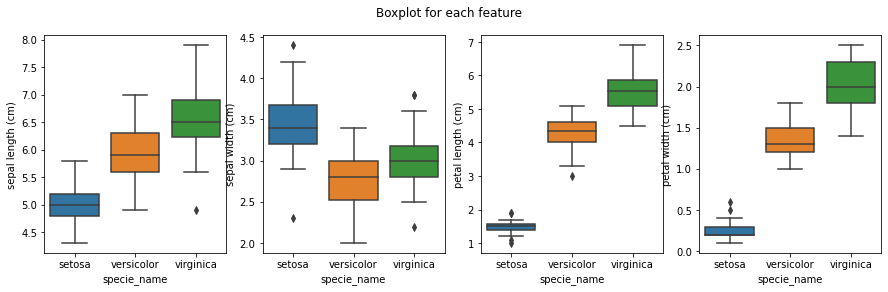

In [421]:
fig, axes = plt.subplots(1, 4, figsize=(15,4))

fig.suptitle("Boxplot for each feature")
for ax, col in zip(axes, ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]):
    sns.boxplot(data = df, x = "specie_name", y = col, ax = ax)


f)

In [422]:
outliers = pd.DataFrame()
for specie in df["specie_name"].unique():
    outliers[f"lower {specie}"] = df[df["specie_name"] == specie].quantile(0.25) - 1.5 * (df[df["specie_name"] == specie].quantile(0.75) - df[df["specie_name"] == specie].quantile(0.25))
    outliers[f"higher {specie}"] = df[df["specie_name"] == specie].quantile(0.75) + 1.5 * (df[df["specie_name"] == specie].quantile(0.75) - df[df["specie_name"] == specie].quantile(0.25))
outliers = outliers.drop("specie")

In [423]:
for specie in df["specie_name"].unique():
    all = df[df["specie_name"] == specie].drop(["specie", "specie_name"], axis=1)
    no_outliers = all[(all > outliers[f"lower {specie}"]) & (all < outliers[f"higher {specie}"])].dropna()
    df = df[~df.isin(all[~all.isin(no_outliers)].dropna())].dropna()

## 1. Split and scale data

In [424]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [425]:
X, y = df.drop(["specie", "specie_name"], axis=1), df["specie"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

print(f"scaled_X_train mean: {scaled_X_train.mean()}, scaled_X_test mean:{scaled_X_test.mean()}")
print(f"scaled_X_train std: {scaled_X_train.std()}, scaled_X_test std:{scaled_X_test.std()}")

scaled_X_train mean: 6.710139159822375e-16, scaled_X_test mean:0.0699532347513562
scaled_X_train std: 1.0, scaled_X_test std:0.9867065209306073


## 2. Classify with logistic regression

In [426]:
from sklearn.linear_model import LogisticRegressionCV

In [441]:
model_logisticCV = LogisticRegressionCV(max_iter=1e4, penalty="elasticnet", solver="saga", l1_ratios=[.005,.05,.1,.2,.3,.4,.5,1])
model_logisticCV.fit(scaled_X_train, y_train)

model_logisticCV.coef_, model_logisticCV.l1_ratio_

(array([[-1.33066694,  1.35077117, -2.26140472, -2.07721863],
        [ 0.4009291 , -0.28604409, -0.58403539, -0.77817815],
        [ 0.67993014, -0.81481013,  3.09481089,  3.10539602]]),
 array([0.2, 0.2, 0.2]))